In [1]:
def mul(*v):
    ret=1
    for x in v:
        ret*=x
    return ret

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm

from torchsummary import summary
from matplotlib import pyplot as plt
import numpy as np
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #gpu driver error, switch to cpu for now
device

device(type='cuda')

In [3]:
l = torchvision.datasets.MNIST(root='./mnist_data/', train = True, download = True, transform = transforms.ToTensor())
t = torchvision.datasets.MNIST(root='./mnist_data/', train = False, download = True, transform = transforms.ToTensor())

In [4]:
l.data.shape,l.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
l.data[0].shape,l.targets[0]

(torch.Size([28, 28]), tensor(5))

In [6]:
img_shape=tuple(l.data[0].shape)
img_dim=mul(*img_shape)
img_shape,img_dim

((28, 28), 784)

In [7]:
x_l=l.data.numpy()
y_l=l.targets.numpy()
x_t=t.data.numpy()
y_t=t.targets.numpy()

In [8]:
IMG_DTYPE=np.float32

#training set
yl=y_l #get selected imgs
xl=x_l.astype(IMG_DTYPE)/255 #color 0~255

#testing set
T_SIZE=1000
yt=y_t[:T_SIZE]
xt=x_t[:T_SIZE].astype(IMG_DTYPE)/255

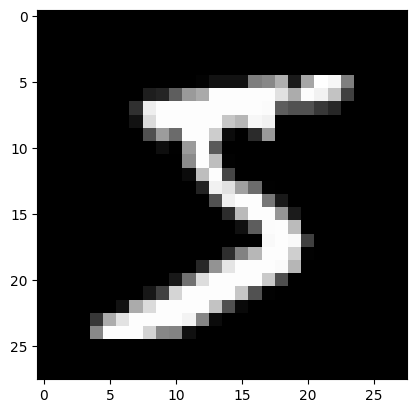

In [9]:
plt.imshow(xl[0], cmap='gray') 

In [10]:
L_BATCH_SIZE=64
T_BATCH_SIZE=100


#create dataloaders
ld=torch.utils.data.DataLoader(
    list(zip(xl,yl)),shuffle=True,batch_size=L_BATCH_SIZE
)
td=torch.utils.data.DataLoader(
    list(zip(xt,yt)),shuffle=True,batch_size=T_BATCH_SIZE
)

In [11]:
Z_DIM=16
MID_DIM=256
class VAE(nn.Module):
    def __init__(self,z_dim=Z_DIM,mid_dim=MID_DIM):
        super().__init__()
        self.fc1 = nn.Linear(img_dim, mid_dim)
        
        self.fc21 = nn.Linear(mid_dim,z_dim) #mu (mean)
        self.fc22 = nn.Linear(mid_dim, z_dim) #sigma (std)


        self.fc3 = nn.Linear(z_dim, mid_dim)
        self.fc4 = nn.Linear(mid_dim,img_dim)
        
    def encode(self,x):
        x=torch.relu(self.fc1(x))
        return self.fc21(x),self.fc22(x)

    def decode(self,x):
        return F.sigmoid(
            self.fc4(
                torch.relu(
                    self.fc3(x)
                )
            )
        )

    def forward(self, x):
        mu, log_std = self.encode(
            x.view(-1, img_dim)
        )
        std = torch.exp(log_std*0.5)
        e = torch.randn_like(std)
        return self.decode(mu+std*e),mu,std,log_std

In [12]:
def loss_fn(x, y, mu, std, log_std): 
    '''BCE + KLD'''
    return F.binary_cross_entropy(y, x.view(-1, img_dim), reduction='sum') + \
        torch.sum(1 + log_std - mu**2 - std**2)* -0.5

In [13]:
model=VAE().to(device)
op=torch.optim.Adam(
    model.parameters(),
    lr=0.002
)

In [14]:
I=torch.eye(Z_DIM).to(device)*3
I

tensor([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [15]:
test=I[[0,1,2,3,4,5,6,7,8,9,0,0,0,0,0,0]]
test,test.shape

(tensor([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
         [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [3., 0., 0., 0.,

In [16]:
def l_step(
    model: torch.nn.Module,
    dl: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    op: torch.optim.Optimizer,
    epochs:int=50
):
    # Put model in train mode
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx,(x,tag) in enumerate(dl):
            
            x,tag=x.to(device),tag.to(device)

            # 1. Forward pass
            y,mu,std,log_std = model(x)

            # 2. Caculate the loss
            loss=loss_fn(x,y,mu-I[tag],std,log_std)

            # 3. Optimizer zero grad
            op.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            op.step()

            epoch_loss+=loss.item()
        
        if epoch%10==0:
            print(epoch_loss)
            
    model.eval()


In [17]:
l_step(
    model,
    ld,
    loss_fn,
    op,
    100
)

8246276.985839844
6280008.027587891
6188451.770263672
6141556.296630859
6111739.033935547
6093547.2412109375
6075887.980224609
6060694.091308594
6053357.153808594
6046510.107666016


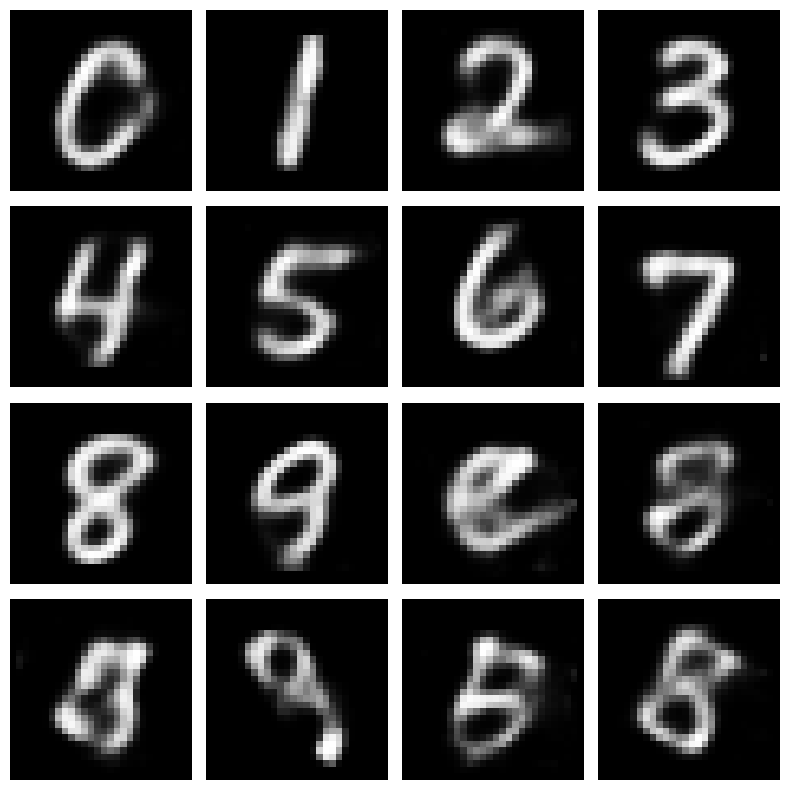

In [18]:
"""
sample at mu (stuff after 9 should not carry any meaning)
"""


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# Loop through the axes and images
for i,ax in enumerate(axes.ravel()):
    ax.imshow(model.decode(I[i]).cpu().view(*img_shape).detach().numpy(), cmap='gray')  # Display each image
    ax.axis('off')  # Hide axes for better visualization

plt.tight_layout()
plt.show()

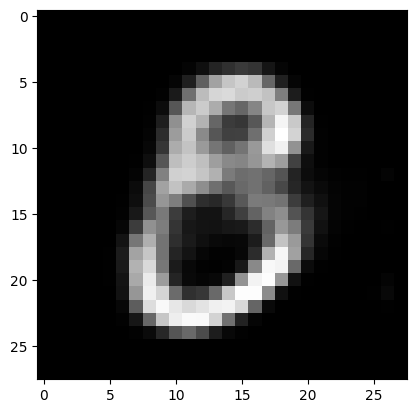

In [19]:
#mid point between 0 and 3

plt.imshow(model.decode((I[0]+I[3])*0.5).cpu().view(*img_shape).detach().numpy(), cmap='gray') 

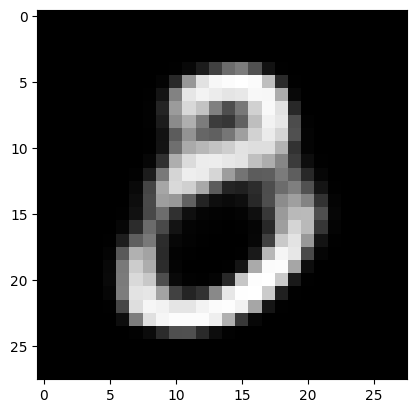

In [20]:
#sum 0 and 3

plt.imshow(model.decode(I[0]+I[3]).cpu().view(*img_shape).detach().numpy(), cmap='gray') 

In [21]:
def sample(num,std=0.25):
    return I[num]+torch.normal(0,std,size=(1,Z_DIM)).to(device)


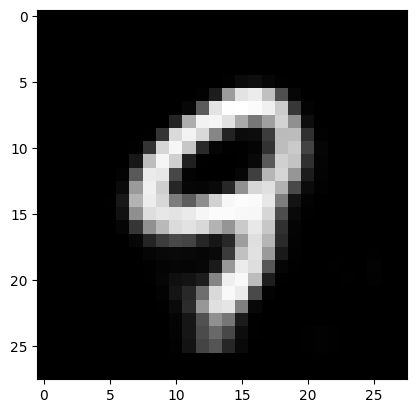

In [22]:
plt.imshow(model.decode(sample(9,0.5)).cpu().view(*img_shape).detach().numpy(), cmap='gray') 

NEXT GOAL:

try to train on the shifted mu instead of shifting the mu on training (shifting the mu on training make distant means unusable)

MORE GOALS (working toward img gen model):

text embeding instead of manually set mus

design a loss function that trains std (not just try to fix it to 1)